In [0]:
!unzip '/content/drive/My Drive/Colab Notebooks/Dataset/SO_Tag_predictor/Train.zip'

In [0]:
d = '/content/drive/My Drive/Colab Notebooks/Dataset/SO_Tag_predictor/'

In [0]:
import warnings, re, os, csv, sqlite3
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sqlalchemy import create_engine # database connection
import datetime as dt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression

try:
    from skmultilearn.adapt import mlknn
    from skmultilearn.adapt import mlknn
    from skmultilearn.problem_transform import ClassifierChain
    from skmultilearn.problem_transform import BinaryRelevance
    from skmultilearn.problem_transform import LabelPowerset
except:
    !pip3 install scikit-multilearn
    from skmultilearn.adapt import mlknn
    from skmultilearn.problem_transform import ClassifierChain
    from skmultilearn.problem_transform import BinaryRelevance
    from skmultilearn.problem_transform import LabelPowerset
    
from sklearn.naive_bayes import GaussianNB
from datetime import datetime

     |████████████████████████████████| 92kB 4.1MB/s 


# Stack Overflow: Tag Prediction

# 1. Business Problem 

## 1.1 Description

**Description** 
* Stack Overflow is the largest, most trusted online community for developers to learn, share their programming knowledge, and build their careers.
* Stack Overflow is something which every programmer use one way or another. Each month, over 50 million developers come to Stack Overflow to learn, share their knowledge, and build their careers. It features questions and answers on a wide range of topics in computer programming. The website serves as a platform for users to ask and answer questions, and, through membership and active participation, to vote questions and answers up or down and edit questions and answers in a fashion similar to a wiki or Digg. As of April 2014 Stack Overflow has over 4,000,000 registered users, and it exceeded 10,000,000 questions in late August 2015. Based on the type of tags assigned to questions, the top eight most discussed topics on the site are: Java, JavaScript, C#, PHP, Android, jQuery, Python and HTML.

**Problem Statemtent** 
* Suggest the tags based on the content that was there in the question posted on Stackoverflow.

**Source:** https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/</p>


## 1.2 Source / useful links 

Data Source : https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/data <br>
Youtube : https://youtu.be/nNDqbUhtIRg <br>
Research paper : https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tagging-1.pdf <br>
Research paper : https://dl.acm.org/citation.cfm?id=2660970&dl=ACM&coll=DL

## 1.3 Real World / Business Objectives and Constraints

1. Predict as many tags as possible with high precision and recall.
2. Incorrect tags could impact customer experience on StackOverflow.
3. No strict latency constraints.

# 2. Machine Learning problem

## 2.1 Data

### 2.1.1 Data Overview 

Refer: https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/data
<br>
All of the data is in 2 files: Train and Test.<br />
<pre>
<b>Train.csv</b> contains 4 columns: Id,Title,Body,Tags.<br />
<b>Test.csv</b> contains the same columns but without the Tags, which you are to predict.<br />
<b>Size of Train.csv</b> - 6.75GB<br />
<b>Size of Test.csv</b> - 2GB<br />
<b>Number of rows in Train.csv</b> = 6034195<br />
</pre>
The questions are randomized and contains a mix of verbose text sites as well as sites related to math and programming. The number of questions from each site may vary, and no filtering has been performed on the questions (such as closed questions).<br />
<br />


__Data Field Explaination__

Dataset contains 6,034,195 rows. The columns in the table are:<br />
<pre>
<b>Id</b> - Unique identifier for each question<br />
<b>Title</b> - The question's title<br />
<b>Body</b> - The body of the question<br />
<b>Tags</b> - The tags associated with the question in a space-seperated format (all lowercase, should not contain tabs '\t' or ampersands '&')<br />
</pre>

<br />

### 2.1.2 Example Data point

<pre>
<b>Title</b>:  Implementing Boundary Value Analysis of Software Testing in a C++ program?
<b>Body </b>: <pre><code>
        #include&lt;
        iostream&gt;\n
        #include&lt;
        stdlib.h&gt;\n\n
        using namespace std;\n\n
        int main()\n
        {\n
                 int n,a[n],x,c,u[n],m[n],e[n][4];\n         
                 cout&lt;&lt;"Enter the number of variables";\n         cin&gt;&gt;n;\n\n         
                 cout&lt;&lt;"Enter the Lower, and Upper Limits of the variables";\n         
                 for(int y=1; y&lt;n+1; y++)\n         
                 {\n                 
                    cin&gt;&gt;m[y];\n                 
                    cin&gt;&gt;u[y];\n         
                 }\n         
                 for(x=1; x&lt;n+1; x++)\n         
                 {\n                 
                    a[x] = (m[x] + u[x])/2;\n         
                 }\n         
                 c=(n*4)-4;\n         
                 for(int a1=1; a1&lt;n+1; a1++)\n         
                 {\n\n             
                    e[a1][0] = m[a1];\n             
                    e[a1][1] = m[a1]+1;\n             
                    e[a1][2] = u[a1]-1;\n             
                    e[a1][3] = u[a1];\n         
                 }\n         
                 for(int i=1; i&lt;n+1; i++)\n         
                 {\n            
                    for(int l=1; l&lt;=i; l++)\n            
                    {\n                 
                        if(l!=1)\n                 
                        {\n                    
                            cout&lt;&lt;a[l]&lt;&lt;"\\t";\n                 
                        }\n            
                    }\n            
                    for(int j=0; j&lt;4; j++)\n            
                    {\n                
                        cout&lt;&lt;e[i][j];\n                
                        for(int k=0; k&lt;n-(i+1); k++)\n                
                        {\n                    
                            cout&lt;&lt;a[k]&lt;&lt;"\\t";\n               
                        }\n                
                        cout&lt;&lt;"\\n";\n            
                    }\n        
                 }    \n\n        
                 system("PAUSE");\n        
                 return 0;    \n
        }\n
        </code></pre>\n\n
        <p>The answer should come in the form of a table like</p>\n\n
        <pre><code>       
        1            50              50\n       
        2            50              50\n       
        99           50              50\n       
        100          50              50\n       
        50           1               50\n       
        50           2               50\n       
        50           99              50\n       
        50           100             50\n       
        50           50              1\n       
        50           50              2\n       
        50           50              99\n       
        50           50              100\n
        </code></pre>\n\n
        <p>if the no of inputs is 3 and their ranges are\n
        1,100\n
        1,100\n
        1,100\n
        (could be varied too)</p>\n\n
        <p>The output is not coming,can anyone correct the code or tell me what\'s wrong?</p>\n'
<b>Tags </b>: 'c++ c'
</pre>

## 2.2 Mapping the real-world problem to a Machine Learning Problem

### 2.2.1 Type of Machine Learning Problem 

<p> It is a multi-label classification problem  <br>
<b>Multi-label Classification</b>: Multilabel classification assigns to each sample a set of target labels. This can be thought as predicting properties of a data-point that are not mutually exclusive, such as topics that are relevant for a document. A question on Stackoverflow might be about any of C, Pointers, FileIO and/or memory-management at the same time or none of these. <br>
__Credit__: http://scikit-learn.org/stable/modules/multiclass.html
</p>

### 2.2.2 Performance metric

<b>Micro-Averaged F1-Score (Mean F Score) </b>: 
The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

<i>F1 = 2 * (precision * recall) / (precision + recall)</i><br>

In the multi-class and multi-label case, this is the weighted average of the F1 score of each class. <br>

<b>'Micro f1 score': </b><br>
Calculate metrics globally by counting the total true positives, false negatives and false positives. This is a better metric when we have class imbalance.
<br>

<b>'Macro f1 score': </b><br>
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
<br>

https://www.kaggle.com/wiki/MeanFScore <br>
http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html <br>
<br>
<b> Hamming loss </b>: The Hamming loss is the fraction of labels that are incorrectly predicted. <br>
https://www.kaggle.com/wiki/HammingLoss <br>

# 3. Exploratory Data Analysis 

## 3.1 Data Loading and Cleaning

### 3.1.1 Using Pandas with SQLite to Load the data

In [0]:
#Creating db file from csv
#Learn SQL: https://www.w3schools.com/sql/default.asp
if not os.path.isfile(d+'train.db'):
    start = datetime.now()
    disk_engine = create_engine('sqlite:///'+d+'train.db')
    start = dt.datetime.now()
    chunksize = 180000
    j = 0
    index_start = 1
    for df in pd.read_csv('Train.csv', names=['Id', 'Title', 'Body', 'Tags'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j += 1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1
    print("Time taken to run this cell :", datetime.now() - start)

### 3.1.2 Counting the number of rows

In [0]:
if os.path.isfile(d+'train.db'):
    start = datetime.now()
    con = sqlite3.connect(d+'train.db')
    num_rows = pd.read_sql_query("""SELECT count(*) FROM data""", con)
    #Always remember to close the database
    print("Number of rows in the database :","\n",num_rows['count(*)'].values[0])
    con.close()
    print("Time taken to count the number of rows :", datetime.now() - start)

Number of rows in the database : 
 6034196
Time taken to count the number of rows : 0:00:40.147460


### 3.1.3 Checking for duplicates

In [0]:
#Learn SQl: https://www.w3schools.com/sql/default.asp
if os.path.isfile(d+'train.db'):
    start = datetime.now()
    con = sqlite3.connect(d+'train.db')
    df_no_dup = pd.read_sql_query('SELECT Title, Body, Tags, COUNT(*) as cnt_dup FROM data GROUP BY Title, Body, Tags', con)
    con.close()
    print("Time taken to run this cell :", datetime.now() - start)

df_no_dup.head()

Time taken to run this cell : 0:01:19.203476


,Title,Body,Tags,cnt_dup
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2


* We can observe that there are duplicates.

In [0]:
print("number of duplicate questions :", num_rows['count(*)'].values[0]- df_no_dup.shape[0], 
      "(i.e.",(1-((df_no_dup.shape[0])/(num_rows['count(*)'].values[0])))*100,"% )")

number of duplicate questions : 1827881 (i.e. 30.292038906260256 % )


**Checking NaN values in dataframe**

In [0]:
nan_df = df_no_dup[df_no_dup.isnull().any(1)]
print('There are total {} NaN values'.format(df_no_dup.isnull().values.sum()))
nan_df

There are total 7 NaN values


,Title,Body,Tags,cnt_dup
777547,Do we really need NULL?,<blockquote>\n <p><strong>Possible Duplicate:...,None,1
962680,Find all values that are not null and not in a...,<p>I am running into a problem which results i...,None,1
1126558,Handle NullObjects,<p>I have done quite a bit of research on best...,None,1
1256102,How do Germans call null,"<p>In german null means 0, so how do they call...",None,1
2430668,Page cannot be null. Please ensure that this o...,<p>I get this error when i remove dynamically ...,None,1
3329908,"What is the difference between NULL and ""0""?","<p>What is the difference from NULL and ""0""?</...",None,1
3551595,a bit of difference between null and space,<p>I was just reading this quote</p>\n\n<block...,None,2


* Dropping the rows where None is present.

In [0]:
df_no_dup.dropna(axis = 0, how = 'any', inplace = True)
nan_df = df_no_dup[df_no_dup.isnull().any(1)]
print('There are total {} NaN values.'.format(df_no_dup.isnull().values.sum()))
nan_df

There are total 0 NaN values.


,Title,Body,Tags,cnt_dup


**Adding the tag count feature**
 * tag_count

In [0]:
start = datetime.now()
df_no_dup["tag_count"] = df_no_dup["Tags"].apply(lambda text: len(text.split(" ")))
# adding a new feature number of tags per question
print("Time taken to run this cell :", datetime.now() - start)
df_no_dup.head()

Time taken to run this cell : 0:00:02.294081


,Title,Body,Tags,cnt_dup,tag_count
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1,2
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1,3
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1,4
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1,2
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2,2


In [0]:
# distribution of number of tags per question
print(df_no_dup['tag_count'].value_counts())

#Creating a new database with no duplicates
if not os.path.isfile(d+'train_no_dup.db'):
    disk_dup = create_engine("sqlite:///"+d+"train_no_dup.db")
    no_dup = pd.DataFrame(df_no_dup, columns=['Title', 'Body', 'Tags'])
    no_dup.to_sql('no_dup_train',disk_dup)

#This method seems more appropriate to work with this much data.
#creating the connection with database file.
if os.path.isfile(d+'train_no_dup.db'):
    start = datetime.now()
    con = sqlite3.connect(d+'train_no_dup.db')
    tag_data = pd.read_sql_query("""SELECT Tags FROM no_dup_train""", con)
    #Always remember to close the database
    con.close()

    # Let's now drop unwanted column.
    tag_data.drop(tag_data.index[0], inplace=True)
    #Printing first 5 columns from our data frame
    tag_data.head()
    print("\nTime taken to run this cell :", datetime.now() - start)

3    1206157
2    1111706
4     814996
1     568291
5     505158
Name: tag_count, dtype: int64

Time taken to run this cell : 0:00:31.463164


## 3.2 Analysis of Tags

### 3.2.1 Total number of unique tags

In [0]:
# Importing & Initializing the "CountVectorizer" object, which is scikit-learn's bag of words tool.

#by default 'split()' will tokenize each tag using space.
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
tag_dtm = vectorizer.fit_transform(tag_data['Tags'])

print("Number of data points :", tag_dtm.shape[0])
print("Number of unique tags :", tag_dtm.shape[1])

#'get_feature_name()' gives us the vocabulary.
tags = vectorizer.get_feature_names()
#Lets look at the tags we have.
print("Some of the tags we have :", tags[:10])

Number of data points : 4206307
Number of unique tags : 42048
Some of the tags we have : ['.a', '.app', '.asp.net-mvc', '.aspxauth', '.bash-profile', '.class-file', '.cs-file', '.doc', '.drv', '.ds-store']


### 3.2.3 Number of times a tag appeared

In [0]:
# https://stackoverflow.com/questions/15115765/how-to-access-sparse-matrix-elements
#Lets now store the document term matrix in a dictionary.
freqs = tag_dtm.sum(axis=0).A1
result = dict(zip(tags, freqs))

#Saving this dictionary to csv files.
if not os.path.isfile(d+'tag_counts_dict_dtm.csv'):
    with open(d+'tag_counts_dict_dtm.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in result.items():
            writer.writerow([key, value])
tag_df = pd.read_csv(d+"tag_counts_dict_dtm.csv", names=['Tags', 'Counts'])
tag_df.head()

,Tags,Counts
0,.a,18
1,.app,37
2,.asp.net-mvc,1
3,.aspxauth,21
4,.bash-profile,138


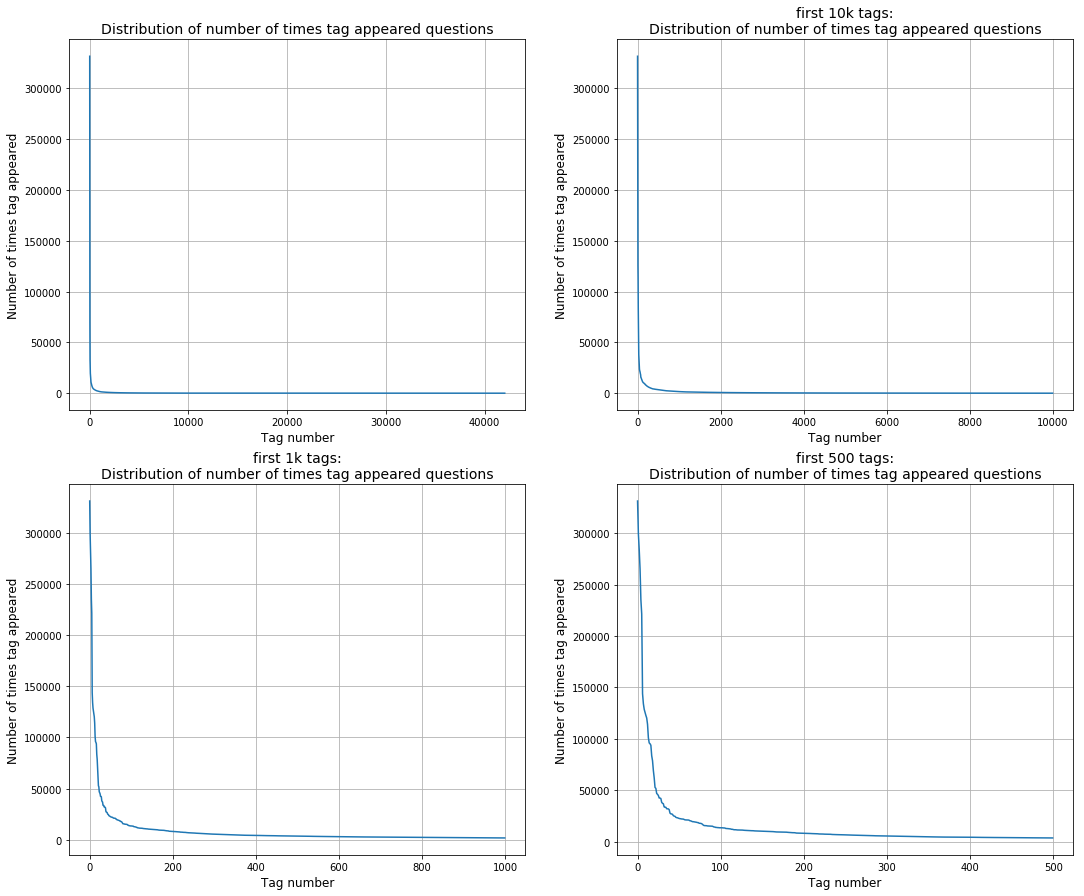

In [0]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted['Counts'].values

fig, [[ax1, ax2],[ax3, ax4]] = plt.subplots(2,2, figsize = (18, 15))

ax1.plot(tag_counts)
ax1.set_title("Distribution of number of times tag appeared questions", fontsize= 14)
ax1.grid()
ax1.set_xlabel("Tag number", fontsize = 12)
ax1.set_ylabel("Number of times tag appeared", fontsize = 12)

ax2.plot(tag_counts[0:10000])
ax2.set_title('first 10k tags:\nDistribution of number of times tag appeared questions', fontsize= 14)
ax2.grid()
ax2.set_xlabel("Tag number", fontsize = 12)
ax2.set_ylabel("Number of times tag appeared", fontsize = 12)

ax3.plot(tag_counts[0:1000])
ax3.set_title('first 1k tags:\nDistribution of number of times tag appeared questions', fontsize= 14)
ax3.grid()
ax3.set_xlabel("Tag number", fontsize = 12)
ax3.set_ylabel("Number of times tag appeared", fontsize = 12)

ax4.plot(tag_counts[0:500])
ax4.set_title('first 500 tags:\nDistribution of number of times tag appeared questions', fontsize= 14)
ax4.grid()
ax4.set_xlabel("Tag number", fontsize = 12)
ax4.set_ylabel("Number of times tag appeared", fontsize = 12)

plt.show()

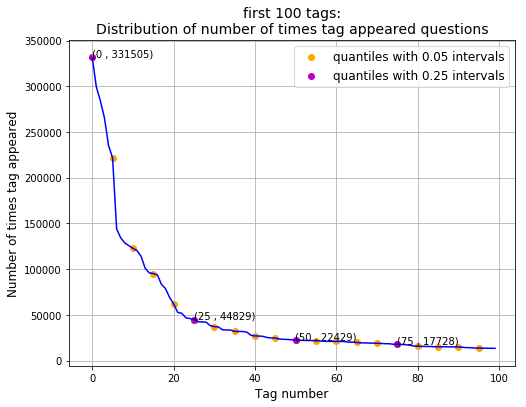

In [0]:
plt.figure(figsize = (8,6))
plt.plot(tag_counts[0:100], c='b')
plt.scatter(x=list(range(0,100,5)), y=tag_counts[0:100:5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=list(range(0,100,25)), y=tag_counts[0:100:25], c='m', label = "quantiles with 0.25 intervals")

for x,y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))

plt.title('first 100 tags:\nDistribution of number of times tag appeared questions', fontsize = 14)
plt.grid()
plt.xlabel("Tag number", fontsize = 12)
plt.ylabel("Number of times tag appeared", fontsize = 12)
plt.legend(fontsize = 12)
plt.show()

In [0]:
# Store tags greater than 10K in one list
lst_tags_gt_10k = tag_df[tag_df.Counts>10000].Tags
#Print the length of the list
print ('{} Tags are used more than 10000 times'.format(len(lst_tags_gt_10k)))

# Store tags greater than 100K in one list
lst_tags_gt_100k = tag_df[tag_df.Counts>100000].Tags
#Print the length of the list.
print ('{} Tags are used more than 100000 times'.format(len(lst_tags_gt_100k)))

153 Tags are used more than 10000 times
14 Tags are used more than 100000 times


<b>Observations:</b><br />
1. There are total 153 tags which are used more than 10000 times.
2. 14 tags are used more than 100000 times.
3. Most frequent tag (i.e. c#) is used 331505 times.
4. Since some tags occur much more frequenctly than others, Micro-averaged F1-score is the appropriate metric for this probelm.

### 3.2.4 Tags Per Question

We have total 4206307 datapoints.
Tag count of first five datapoint is:  [3, 4, 2, 2, 3]
Maximum number of tags per question: 5
Minimum number of tags per question: 1
Avg. number of tags per question: 2.899443





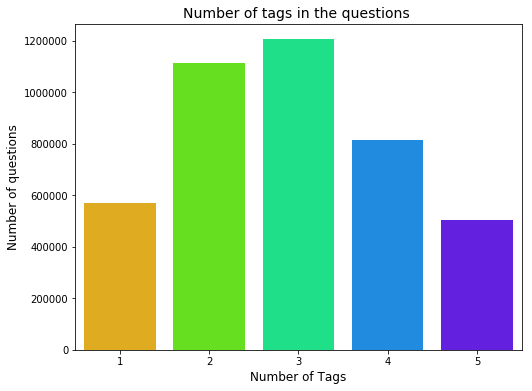

In [0]:
#Storing the count of tag in each question in list 'tag_count'
tag_quest_count = tag_dtm.sum(axis=1).tolist()

#Converting list of lists into single list, we will get [[3], [4], [2], [2], [3]] and we are converting this to [3, 4, 2, 2, 3]
tag_quest_count = [int(j) for i in tag_quest_count for j in i]

print('We have total {} datapoints.'.format(len(tag_quest_count)))
print('Tag count of first five datapoint is: ',tag_quest_count[:5])
print("Maximum number of tags per question: %d"%max(tag_quest_count))
print("Minimum number of tags per question: %d"%min(tag_quest_count))
print("Avg. number of tags per question: %f"% ((sum(tag_quest_count)*1.0)/len(tag_quest_count)))

print('\n\n')
plt.figure(figsize = (8,6))
sns.countplot(tag_quest_count, palette='gist_rainbow')
plt.title("Number of tags in the questions ", fontsize = 14)
plt.xlabel("Number of Tags", fontsize = 12)
plt.ylabel("Number of questions", fontsize = 12)
plt.show()

<b>Observations:</b><br />
1. Maximum number of tags per question: 5
2. Minimum number of tags per question: 1
3. Avg. number of tags per question: 2.899
4. Most of the questions are having 2 or 3 tags

### 3.2.5 Most Frequent Tags

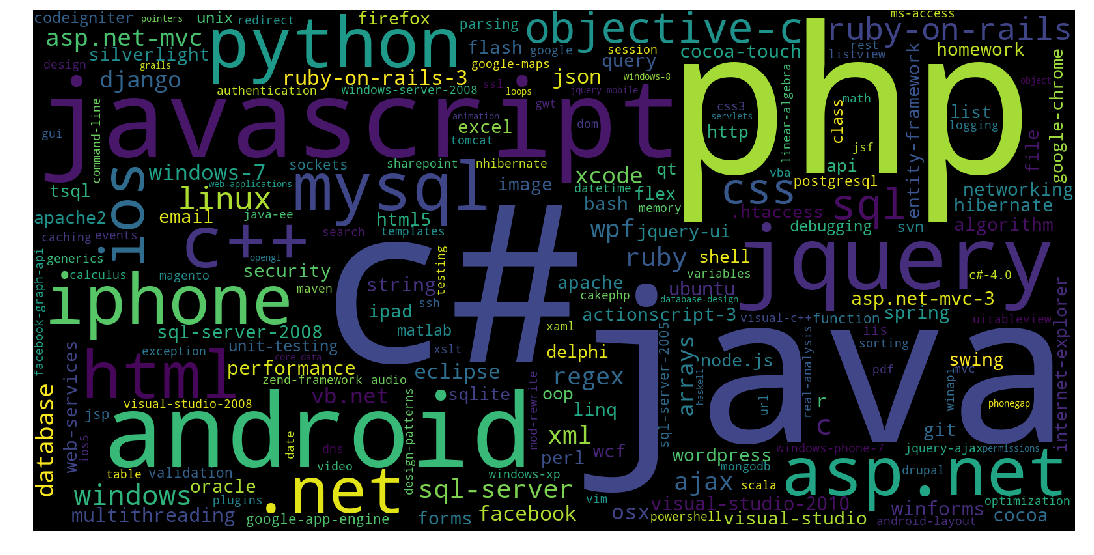

Time taken to run this cell : 0:00:02.952537


In [0]:
# Ploting word cloud
start = datetime.now()

# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.: https://stackoverflow.com/a/51895005
wordcloud = WordCloud(background_color='black', width= 1600, height= 800,min_font_size = 10).generate_from_frequencies(tup)

fig = plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()
print("Time taken to run this cell :", datetime.now() - start)

<b>Observations:</b><br />
A look at the word cloud shows that "c#", "java", "php", "asp.net", "javascript", "c++" are some of the most frequent tags.

### 3.2.6 The top 20 tags 

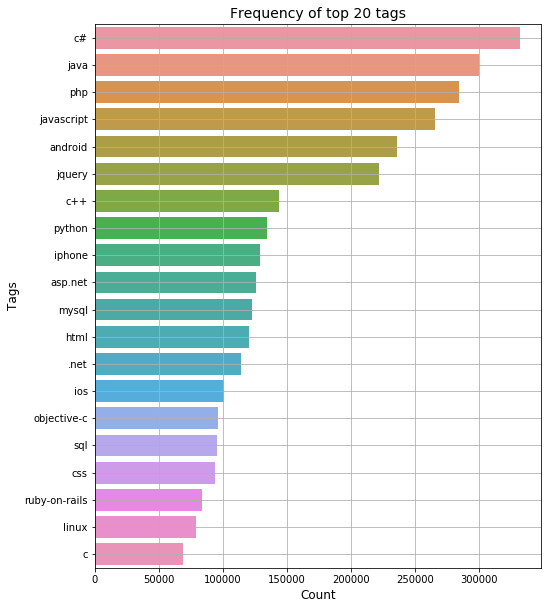

In [0]:
# tag_df_sorted.head(20).barplot()
plt.figure(figsize = (8,10))
sns.barplot(x = 'Counts', y = 'Tags', data = tag_df_sorted.head(20))
plt.title('Frequency of top 20 tags', fontsize = 14)
plt.xlabel('Count', fontsize = 12)
plt.ylabel('Tags', fontsize = 12)
plt.grid(1)
plt.show()

<b>Observations:</b><br />
1. Majority of the most frequent tags are programming language.
2. C# is the top most frequent programming language.
3. Android, IOS, Linux and windows are among the top most frequent operating systems.

## 3.3 Cleaning and preprocessing of Questions

### 3.3.1 Preprocessing

<ol> 
    <li> Sample 1M data points </li>
    <li> Separate out code-snippets from Body </li>
    <li> Remove Spcial characters from Question title and description (not in code)</li>
    <li> Remove stop words (Except 'C') </li>
    <li> Remove HTML Tags </li>
    <li> Convert all the characters into small letters </li>
    <li> Use SnowballStemmer to stem the words </li>
</ol>

In [0]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')  

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [0]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

def create_database_table(database, query):
    conn = create_connection(database)
    if conn is not None:
        create_table(conn, query)
        checkTableExists(conn)
    else:
        print("Error! cannot create the database connection.")
    conn.close()

sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (
question text NOT NULL, 
code text, tags text, 
words_pre integer, 
words_post integer, 
is_code integer);"""

create_database_table(d+"Processed.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


In [0]:
# http://www.sqlitetutorial.net/sqlite-delete/
start = datetime.now()
read_db = d+'train_no_dup.db'
write_db = d+'Processed.db'
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader =conn_r.cursor()

        # to select random row: https://stackoverflow.com/questions/2279706/select-random-row-from-a-sqlite-table
        reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() LIMIT 1000000;")

if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer =conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared All the rows")
print("Time taken to run this cell :", datetime.now() - start)

Tables in the databse:
QuestionsProcessed
Cleared All the rows
Time taken to run this cell : 0:05:31.083351


__we create a new data base to store the sampled and preprocessed questions__

In [0]:
#http://www.bernzilla.com/2008/05/13/selecting-a-random-row-from-an-sqlite-table/
start = datetime.now()
preprocessed_data_list =[]
reader.fetchone()
questions_with_code = 0
len_pre = 0
len_post = 0
questions_proccesed = 0

for row in reader:
    is_code = 0
    title, question, tags = row[0], row[1], row[2]

    if '<code>' in question:
        questions_with_code += 1
        is_code = 1
        
    x = len(question) + len(title)
    len_pre += x

    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))

    question = re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question = striphtml(question.encode('utf-8'))

    title = title.encode('utf-8')

    question = str(title)+" "+str(question)
    question = re.sub(r'[^A-Za-z]+',' ',question)
    words = word_tokenize(str(question.lower()))

    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question = ' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))

    len_post += len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_proccesed%100000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre  = (len_pre*1.0)/questions_proccesed
no_dup_avg_len_post = (len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

number of questions completed= 100000
number of questions completed= 200000
number of questions completed= 300000
number of questions completed= 400000
number of questions completed= 500000
number of questions completed= 600000
number of questions completed= 700000
number of questions completed= 800000
number of questions completed= 900000
Avg. length of questions(Title+Body) before processing: 1171
Avg. length of questions(Title+Body) after processing: 326
Percent of questions containing code: 57
Time taken to run this cell : 0:18:34.039454


In [0]:
# dont forget to close the connections, or else you will end up with locks
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader = conn_r.cursor()
        reader.execute("SELECT question From QuestionsProcessed LIMIT 10")
        print("Questions after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

Questions after preprocessed
('add sdk call dispatchev send event content script page hello simpl firefox extens base add sdk pagemod npagemod inject script page call one function web page event listen ad mydiv addeventlisten nproblem inject script dispatch event page dispatchev function return true noth happen nhere pagemod code run contentscript code firebug consol work need dispatch event contentscript also tri use unsafewindow document instead document use jqueri event event listen work',)
----------------------------------------------------------------------------------------------------
('way defin variabl two type loop work nbut way defin variabl two type loop ni need use iter insid loop total hack obscur solut ok pleas give suggest use float real problem iter stl valu type pleas suggest move variabl outsid bodi probabl usabl iter disappear loop statement enclos foreach macro macro use like need someth use like pleas introduc runtim overhead might slow compil thank advanc',)
---

In [0]:
#Taking 1 Million entries to a dataframe.
write_db = d+'Processed.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])
#top 5 rows of preprocessed_data
preprocessed_data.head()

number of data points in sample : 999999
number of dimensions : 2


,question,tags
0,googl spreadsheet api base applic tri learn go...,c# excel google google-spreadsheet
1,add sdk call dispatchev send event content scr...,javascript firefox javascript-events dispatche...
2,way defin variabl two type loop work nbut way ...,c++ for-loop
3,search problem sql server need search tabl ite...,sql-server query search stored-procedures sql-...
4,rail mysql databas yeah pretti stupid mayb sea...,ruby-on-rails mysql2


# 4. Machine Learning Models

## 4.1 Converting tags for multilabel problems


| X | y1 | y2 | y3 | y4|
|---|----|----|----|---|
|x1 | 0  | 1  | 1  | 0 |
|x2 | 1  | 0  | 1  | 0 |
|x3 | 0  | 1  | 0  | 1 |
|x4 | 1  | 0  | 0  | 1 |

In [0]:
# binary='true' will give a binary vectorizer
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

__We will sample the number of tags instead considering all of them (due to limitation of computing power)__

In [0]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [0]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

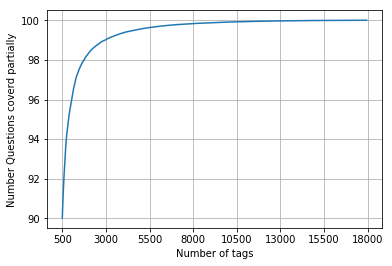

with  5500 tags we are covering  99.025 % of questions


In [0]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 50(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")

In [0]:
multilabel_yx = tags_to_choose(5500)
print("number of questions that are not covered :", questions_explained_fn(5500),"out of ", total_qs)

print("Number of tags in sample :", multilabel_y.shape[1])
print("number of tags taken :", multilabel_yx.shape[1],"(",(multilabel_yx.shape[1]/multilabel_y.shape[1])*100,"%)")

number of questions that are not covered : 9751 out of  999999
Number of tags in sample : 35487
number of tags taken : 5500 ( 15.498633302336067 %)


__We consider top 15% tags which covers  99% of the questions__

## 4.2 Split the data into test and train (80:20)

In [0]:
total_size=preprocessed_data.shape[0]
train_size=int(0.80*total_size)

x_train=preprocessed_data.head(train_size)
x_test=preprocessed_data.tail(total_size - train_size)

y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (799999, 5500)
Number of data points in test data : (200000, 5500)


## 4.3 Featurizing data

In [0]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])

print("Time taken to run this cell :", datetime.now() - start)
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Time taken to run this cell : 0:07:39.846426
Dimensions of train data X: (799999, 87986) Y : (799999, 5500)
Dimensions of test data X: (200000, 87986) Y: (200000, 5500)


In [0]:
# https://www.analyticsvidhya.com/blog/2017/08/introduction-to-multi-label-classification/
#https://stats.stackexchange.com/questions/117796/scikit-multi-label-classification
# classifier = LabelPowerset(GaussianNB())
"""
from skmultilearn.adapt import MLkNN
classifier = MLkNN(k=21)

# train
classifier.fit(x_train_multilabel, y_train)

# predict
predictions = classifier.predict(x_test_multilabel)
print(accuracy_score(y_test,predictions))
print(metrics.f1_score(y_test, predictions, average = 'macro'))
print(metrics.f1_score(y_test, predictions, average = 'micro'))
print(metrics.hamming_loss(y_test,predictions))

"""
# we are getting memory error because the multilearn package 
# is trying to convert the data into dense matrix
# ---------------------------------------------------------------------------
#MemoryError                               Traceback (most recent call last)
#<ipython-input-170-f0e7c7f3e0be> in <module>()
#----> classifier.fit(x_train_multilabel, y_train)

## 4.4 Applying Logistic Regression with OneVsRest Classifier

In [0]:
# this will be taking so much time try not to run it, download the lr_with_equal_weight.pkl file and use to predict
# This takes about 6-7 hours to run.
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions))


accuracy : 0.081965
macro f1 score : 0.0963020140154
micro f1 scoore : 0.374270748817
hamming loss : 0.00041225090909090907
Precision recall report :
              precision    recall  f1-score   support

          0       0.62      0.23      0.33     15760
          1       0.79      0.43      0.56     14039
          2       0.82      0.55      0.66     13446
          3       0.76      0.42      0.54     12730
          4       0.94      0.76      0.84     11229
          5       0.85      0.64      0.73     10561
          6       0.70      0.30      0.42      6958
          7       0.87      0.61      0.72      6309
          8       0.70      0.40      0.50      6032
          9       0.78      0.43      0.55      6020
         10       0.86      0.62      0.72      5707
         11       0.52      0.17      0.25      5723
         12       0.55      0.10      0.16      5521
         13       0.59      0.25      0.35      4722
         14       0.61      0.22      0.32      4468


In [0]:
# this will be taking so much time try not to run it, download the lr_with_equal_weight.pkl file and use to predict
# This takes about 6-7 hours to run.
import joblib

if not os.path.isfile(d+'lr_with_equal_weight.pkl'):
    classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
    classifier.fit(x_train_multilabel, y_train)
    predictions = classifier.predict(x_test_multilabel)
    
    with open(d+'lr_with_equal_weight.pkl', 'wb') as f:
        joblib.dump(classifier, f)
else:
    with open(d+'lr_with_equal_weight.pkl', 'rb') as f:
        joblib.load(f)
    predictions = classifier.predict(x_test_multilabel)
    
print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions))


## 4.5 Modeling with less data points (100k data points) and more weight to title and 500 tags only.

### 4.5.1 Preprocessing of questions

<ol> 
    <li> Separate Code from Body </li>
    <li> Remove Spcial characters from Question title and description (not in code)</li>
    <li> <b> Give more weightage to title : Add title three times to the question </b> </li>
   
    <li> Remove stop words (Except 'C') </li>
    <li> Remove HTML Tags </li>
    <li> Convert all the characters into small letters </li>
    <li> Use SnowballStemmer to stem the words </li>
</ol>

In [0]:
sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table(d+"Titlemoreweight.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


In [0]:
# http://www.sqlitetutorial.net/sqlite-delete/
# https://stackoverflow.com/questions/2279706/select-random-row-from-a-sqlite-table

read_db = d+'train_no_dup.db'
write_db = d+'Titlemoreweight.db'
train_datasize = 80000
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        # for selecting first 100k rows
        reader.execute("SELECT Title, Body, Tags From no_dup_train LIMIT 100001;")
        # for selecting random points
        #reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() LIMIT 100001;")

if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer =conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared All the rows")

Tables in the databse:
QuestionsProcessed
Cleared All the rows


In [0]:
#http://www.bernzilla.com/2008/05/13/selecting-a-random-row-from-an-sqlite-table/
start = datetime.now()
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0

for row in reader:    
    is_code = 0    
    title, question, tags = row[0], row[1], str(row[2])
    
    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
        
    x = len(question)+len(title)
    len_pre += x
    
    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))    
    question = re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question = striphtml(question.encode('utf-8'))
     
    title = title.encode('utf-8')
    
    # adding title three time to the data to increase its weight
    # add tags string to the training data
    
    question = str(title)+" "+str(title)+" "+str(title)+" "+question
    
    question = re.sub(r'[^A-Za-z0-9#+.\-]+',' ',question)
    words = word_tokenize(str(question.lower()))
    
    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question = ' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    
    len_post += len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_proccesed%100000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

# never forget to close the conections or else we will end up with database locks
# closing the connection
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

number of questions completed= 100000
Avg. length of questions(Title+Body) before processing: 1232
Avg. length of questions(Title+Body) after processing: 441
Percent of questions containing code: 57
Time taken to run this cell : 0:02:43.956493


__Sample quesitons after preprocessing of data__

In [0]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT question From QuestionsProcessed LIMIT 10")
        print("Questions after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

Questions after preprocessed
('dynam datagrid bind silverlight dynam datagrid bind silverlight dynam datagrid bind silverlight bind datagrid dynam code wrote code debug code block seem bind correct grid come column form come grid column although necessari bind nthank repli advance..',)
----------------------------------------------------------------------------------------------------
('java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid follow guid link instal jstl got follow error tri launch jsp page java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid taglib declar instal jstl 1.1 tomcat webapp tri project work also tri version 1.2 jstl still messag caus solv',)
----------------------------------------------------------------------------------------------------
('java.sql.sqlexcept microsoft odbc driver

__Saving Preprocessed data to a Database__

In [0]:
#Taking 0.1 Million entries to a dataframe.
write_db = d+'Titlemoreweight.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

preprocessed_data.head()

number of data points in sample : 100000
number of dimensions : 2


,question,tags
0,dynam datagrid bind silverlight dynam datagrid...,c# silverlight data-binding
1,dynam datagrid bind silverlight dynam datagrid...,c# silverlight data-binding columns
2,java.lang.noclassdeffounderror javax servlet j...,jsp jstl
3,java.sql.sqlexcept microsoft odbc driver manag...,java jdbc
4,better way updat feed fb php sdk better way up...,facebook api facebook-php-sdk


__Converting string Tags to multilable output variables__ 

In [0]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

__Selecting 500 Tags__

In [0]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

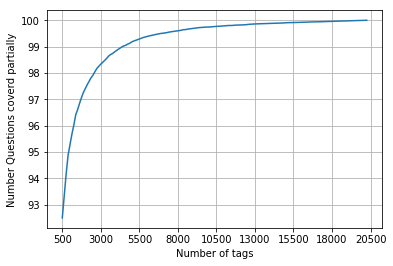

with  5500 tags we are covering  99.481 % of questions
with  500 tags we are covering  92.5 % of questions


In [0]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 500(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")
print("with ",500,"tags we are covering ",questions_explained[0],"% of questions")

In [0]:
# we will be taking 500 tags
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(500),"out of ", total_qs)

# data splitting
x_train=preprocessed_data.head(train_datasize)
x_test=preprocessed_data.tail(preprocessed_data.shape[0] - 80000)

y_train = multilabel_yx[0:train_datasize,:]
y_test = multilabel_yx[train_datasize:preprocessed_data.shape[0],:]

print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

number of questions that are not covered : 7500 out of  100000
Number of data points in train data : (80000, 500)
Number of data points in test data : (20000, 500)


### 4.5.2 Featurizing data with TfIdf vectorizer

#### 4.5.2.1 BoW

**4-grams**

In [0]:
start = datetime.now()
vectorizer = CountVectorizer(min_df = 0.00009, max_features = 200000, tokenizer = lambda x: x.split(), ngram_range = (1,4))
x_train_bow = vectorizer.fit_transform(x_train['question'].values)
x_test_bow  = vectorizer.transform(x_test['question'].values)
print("Time taken for vectorizing:", datetime.now() - start)

print("Dimensions of train data X:",x_train_bow.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_bow.shape,"Y:",y_test.shape)

Time taken for vectorizing: 0:01:23.343020
Dimensions of train data X: (80000, 101734) Y : (80000, 500)
Dimensions of test data X: (20000, 101734) Y: (20000, 500)


#### 4.5.2.2 TF-IDF

**3-grams**

In [0]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_tfidf = vectorizer.fit_transform(x_train['question'].values)
x_test_tfidf = vectorizer.transform(x_test['question'].values)
print("Time taken for vectorizing:", datetime.now() - start)

print("Dimensions of train data X:",x_train_tfidf.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_tfidf.shape,"Y:",y_test.shape)

Time taken for vectorizing: 0:00:49.976794
Dimensions of train data X: (80000, 100247) Y : (80000, 500)
Dimensions of test data X: (20000, 100247) Y: (20000, 500)


### 4.5.3 Applying Logistic Regression with OneVsRest Classifier

**Some Reusable Fuction**

In [0]:
def plot_f1_micro(params, train_score, cv_score, name):
    plt.figure(figsize = (8,6))
    plt.plot(params, train_score, label = 'Train')
    plt.plot(params, cv_score, label = 'CV')
    plt.title('Train and CV score (f1_micor) V/s hyperparameter', fontsize = 14)
    plt.xlabel('Hyperparameter log10('+str(name)+')', fontsize = 12)
    plt.ylabel('f1_micro score', fontsize = 12)
    plt.legend(fontsize = 12)
    plt.grid(1)
    plt.show()

In [0]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

# for tunning
def tune_SgdClassifier(X, Y, loss1):
    alpha1 = [10**i for i in range(-7, 4)]
    #OneVsRest with Gridsearch: https://stackoverflow.com/a/12637528
    params = {'estimator__alpha': alpha1}
    sgd = OneVsRestClassifier(SGDClassifier(loss = loss1, penalty = 'l1'), n_jobs = -1)
    clf = GridSearchCV(sgd, param_grid = params, scoring = 'f1_micro', n_jobs = -1, return_train_score = True, cv = 2) #only two fold
    clf.fit(X, Y)
    
    train_score = clf.cv_results_['mean_train_score'] #train f1_score
    cv_score    = clf.cv_results_['mean_test_score']  #CV f1_score
    
    best_score = clf.best_score_
    best_estimator = clf.best_estimator_ 
    best_alpha = alpha1[np.argmax(cv_score)]
    
    print('Best CV score is: ', best_score)
    print('\nBest estimator is: \n', best_estimator)
    print('\nBest hyperaparamter (alpha) value is: ', best_alpha, '\nBut need validation!\n\n')
    
    plot_f1_micro(np.log10(alpha1), train_score, cv_score, name = 'alpha')
    
    return best_estimator, cv_score
  

# for testing
def test_SgdClassifier(clf, X_train, Y_train, X_test, Y_test, loss1):
  
    clf.fit(X_train, Y_train)
    y_test_pred = clf.predict(X_test)
    
    accuracy = metrics.accuracy_score(Y_test, y_test_pred)
    hamm_loss = metrics.hamming_loss(Y_test,y_test_pred)    
    precison_micro_score = precision_score(Y_test, y_test_pred, average='micro')
    recall_micro_score = recall_score(Y_test, y_test_pred, average='micro')
    f1_micro_score = f1_score(Y_test, y_test_pred, average='micro')
    
    print("Accuracy :", accuracy)
    print("Hamming loss ", hamm_loss)
    print("Micro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precison_micro_score, 
                                                                         recall_micro_score, 
                                                                         f1_micro_score))
        
    return precison_micro_score, recall_micro_score, f1_micro_score, hamm_loss, accuracy

In [0]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable
x = PrettyTable()
x.field_names = ["Model", "Vectorizer", "F1 score", "Precision", "Recall", "Hamming loss", "Accuracy"]

#### 4.5.3.1 BoW

Best CV score is:  0.37626526808829874

Best estimator is: 
 OneVsRestClassifier(estimator=SGDClassifier(alpha=0.001, average=False,
                                            class_weight=None,
                                            early_stopping=False, epsilon=0.1,
                                            eta0=0.0, fit_intercept=True,
                                            l1_ratio=0.15,
                                            learning_rate='optimal', loss='log',
                                            max_iter=1000, n_iter_no_change=5,
                                            n_jobs=None, penalty='l1',
                                            power_t=0.5, random_state=None,
                                            shuffle=True, tol=0.001,
                                            validation_fraction=0.1, verbose=0,
                                            warm_start=False),
                    n_jobs=None)

Best hyperaparamter (alpha) value is:  

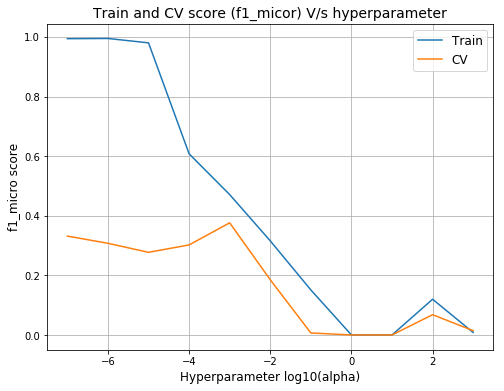

In [0]:
clf1, cv_score = tune_SgdClassifier(x_train_bow, y_train, loss1 = 'log')

In [0]:
pr1, re1, f1_1, ham1, acc1 = test_SgdClassifier(clf1, x_train_bow, y_train, x_test_bow, y_test, loss1 = 'log')
x.add_row(['Logistic Regression','BoW (3-gram)' , f1_1, pr1, re1, ham1, acc1])

Accuracy : 0.13985
Hamming loss  0.0035967
Micro-average quality numbers
Precision: 0.5388, Recall: 0.2789, F1-measure: 0.3676


#### 4.5.3.2 TF-IDF

Best CV score is:  0.43414219109586627

Best estimator is: 
 OneVsRestClassifier(estimator=SGDClassifier(alpha=1e-06, average=False,
                                            class_weight=None,
                                            early_stopping=False, epsilon=0.1,
                                            eta0=0.0, fit_intercept=True,
                                            l1_ratio=0.15,
                                            learning_rate='optimal', loss='log',
                                            max_iter=1000, n_iter_no_change=5,
                                            n_jobs=None, penalty='l1',
                                            power_t=0.5, random_state=None,
                                            shuffle=True, tol=0.001,
                                            validation_fraction=0.1, verbose=0,
                                            warm_start=False),
                    n_jobs=None)

Best hyperaparamter (alpha) value is:  

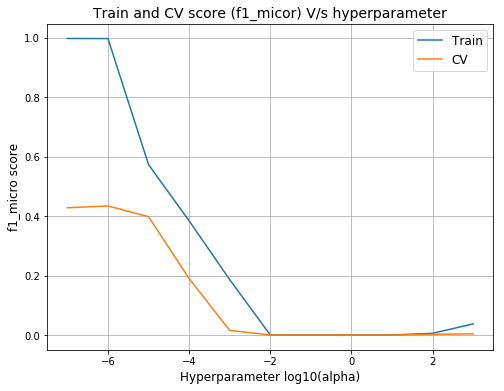

In [0]:
clf2, cv_score = tune_SgdClassifier(x_train_tfidf, y_train, loss1 = 'log')

In [0]:
pr2, re2, f1_2, ham2, acc2 = test_SgdClassifier(clf2, x_train_tfidf, y_train, x_test_tfidf, y_test, loss1 = 'log')
x.add_row(['Logistic Regression', 'TF-IDF (4-grams)', f1_2, pr2, re2, ham1, acc2])

Accuracy : 0.19055
Hamming loss  0.0031347
Micro-average quality numbers
Precision: 0.6451, Recall: 0.3633, F1-measure: 0.4648


### 4.5.4 LinearSVM with OneVSRest Classifier

#### 4.5.4.1 BoW

Best CV score is:  0.346278501791932

Best estimator is: 
 OneVsRestClassifier(estimator=SGDClassifier(alpha=0.001, average=False,
                                            class_weight=None,
                                            early_stopping=False, epsilon=0.1,
                                            eta0=0.0, fit_intercept=True,
                                            l1_ratio=0.15,
                                            learning_rate='optimal',
                                            loss='hinge', max_iter=1000,
                                            n_iter_no_change=5, n_jobs=None,
                                            penalty='l1', power_t=0.5,
                                            random_state=None, shuffle=True,
                                            tol=0.001, validation_fraction=0.1,
                                            verbose=0, warm_start=False),
                    n_jobs=None)

Best hyperaparamter (alpha) value is:  

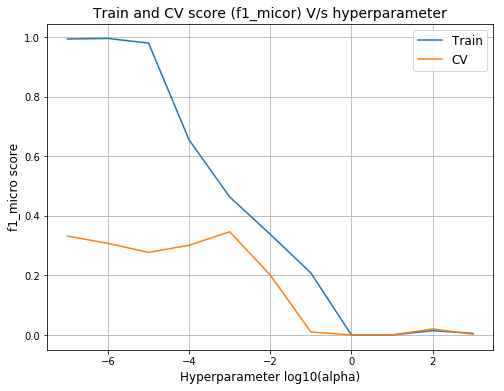

In [0]:
clf3, cv_score = tune_SgdClassifier(x_train_bow, y_train, loss1 = 'hinge')

In [0]:
pr3, re3, f1_3, ham3, acc3 = test_SgdClassifier(clf3, x_train_bow, y_train, x_test_bow, y_test, loss1 = 'hinge')
x.add_row(['SVM','BoW (4-gram)' , f1_3, pr3, re3, ham3, acc3])

Accuracy : 0.1412
Hamming loss  0.0035829
Micro-average quality numbers
Precision: 0.5431, Recall: 0.2761, F1-measure: 0.3661


#### 4.5.4.2 TF-IDF

Best CV score is:  0.44445962717108817

Best estimator is: 
 OneVsRestClassifier(estimator=SGDClassifier(alpha=1e-06, average=False,
                                            class_weight=None,
                                            early_stopping=False, epsilon=0.1,
                                            eta0=0.0, fit_intercept=True,
                                            l1_ratio=0.15,
                                            learning_rate='optimal',
                                            loss='hinge', max_iter=1000,
                                            n_iter_no_change=5, n_jobs=None,
                                            penalty='l1', power_t=0.5,
                                            random_state=None, shuffle=True,
                                            tol=0.001, validation_fraction=0.1,
                                            verbose=0, warm_start=False),
                    n_jobs=None)

Best hyperaparamter (alpha) value is:

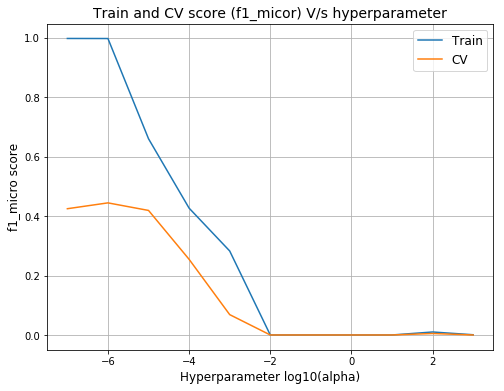

In [0]:
clf4, cv_score = tune_SgdClassifier(x_train_tfidf, y_train, loss1 = 'hinge')

In [0]:
pr4, re4, f1_4, ham4, acc4 = test_SgdClassifier(clf4, x_train_tfidf, y_train, x_test_tfidf, y_test, loss1 = 'hinge')
x.add_row(['SVM','TFIDF (3-gram)', f1_4, pr4, re4, ham4, acc4])

Accuracy : 0.1616
Hamming loss  0.0035218
Micro-average quality numbers
Precision: 0.5420, Recall: 0.3881, F1-measure: 0.4523


# 5. Conclusion

**Summary**
* Given dataset is quite big and there are 6 million datapoints. Each data points contains **Title, Body, and Tags**.
* There are around **44k** different tag labels. But **top 5500 tags** are covering the **99%** (approx.) of the datapoints and **500** tags are covering around **90%** of the datapoints. 
* I'm considering only **100k** datapoints and **500** tags becasue of computation time/cost.
* Code part of **Body** feature as been removed and **Title** feature has been repeated three time to increase the weightage of this feature (**by 3x**).
* Linear model **Logistic Regression** with **3-gram BoW** is best out of four models.
* Performance of these models can be imporved by using more datapoints.

In [0]:
print(x)

+---------------------+------------------+---------------------+--------------------+---------------------+--------------+----------+
|        Model        |    Vectorizer    |       F1 score      |     Precision      |        Recall       | Hamming loss | Accuracy |
+---------------------+------------------+---------------------+--------------------+---------------------+--------------+----------+
| Logistic Regression |   BoW (4-gram)   |  0.3675687081289234 | 0.5387906593123357 |  0.2789282664389411 |  0.0035967   | 0.13985  |
| Logistic Regression | TF-IDF (3-grams) | 0.46480340100049516 | 0.6451490591971184 | 0.36325789923142615 |  0.0035967   | 0.19055  |
|         SVM         |   BoW (4-gram)   | 0.36609401815254505 | 0.5431256233923041 |  0.276099487617421  |  0.0035829   |  0.1412  |
|         SVM         |  TFIDF (3-gram)  |  0.4523202289126648 | 0.5420020870602266 |  0.3881031169940222 |  0.0035218   |  0.1616  |
+---------------------+------------------+--------------------

In [0]:
# https://ptable.readthedocs.io/en/latest/tutorial.html
print(x.get_string(sortby="F1 score", reversesort=True))

+---------------------+------------------+---------------------+--------------------+---------------------+--------------+----------+
|        Model        |    Vectorizer    |       F1 score      |     Precision      |        Recall       | Hamming loss | Accuracy |
+---------------------+------------------+---------------------+--------------------+---------------------+--------------+----------+
| Logistic Regression | TF-IDF (3-grams) | 0.46480340100049516 | 0.6451490591971184 | 0.36325789923142615 |  0.0035967   | 0.19055  |
|         SVM         |  TFIDF (3-gram)  |  0.4523202289126648 | 0.5420020870602266 |  0.3881031169940222 |  0.0035218   |  0.1616  |
| Logistic Regression |   BoW (4-gram)   |  0.3675687081289234 | 0.5387906593123357 |  0.2789282664389411 |  0.0035967   | 0.13985  |
|         SVM         |   BoW (4-gram)   | 0.36609401815254505 | 0.5431256233923041 |  0.276099487617421  |  0.0035829   |  0.1412  |
+---------------------+------------------+--------------------